In [1]:
import time
import numpy as np
from compas.datastructures import Mesh
import networkx 
from networkx.algorithms.components.connected import connected_components
from compas import datastructures
from compas.datastructures import mesh_delete_duplicate_vertices
from compas_plotters.meshplotter import MeshPlotter
from compas.numerical import dr_numpy
from compas.geometry import matrix_from_axis_and_angle
from compas.datastructures import Mesh as CompasMesh
from compas.geometry import area_polygon
from random import seed
from random import randint
from random import choices
from stopit import threading_timeoutable as timeoutable 
import os

In [2]:
#find the centre of xi points
def find_centre(mesh,xi):
    cxi=[]    
    cyi=[]
    czi=[]
    for xa in xi:
        i=Mesh.vertex_coordinates(mesh, xa, axes='x')
        i=i[0]
        cxi.append(i)
        cx=((sum(set(cxi)))/(len(set(cxi))))

        i=Mesh.vertex_coordinates(mesh, xa, axes='y')
        i=i[0]
        cyi.append(i)
        cy=((sum(set(cyi)))/(len(set(cyi))))

        i=Mesh.vertex_coordinates(mesh, xa, axes='z')
        i=i[0]
        czi.append(i)
        cz=((sum(set(czi)))/(len(set(czi))))
        cnt=[cx,cy,cz]
    return cnt

def face_coor(m,fkey): #create a list of the faces structure with sublists of the coordinated of the points
    z=m.face_vertices(fkey)
    coor=[]
    for i in z:
        temp=Mesh.vertex_coordinates(m, i, axes='xyz')
        coor.append(temp)
    return coor

def mesh_vertex_coordinates(m): #list of coordinates for all vertices
    vertices = list(m.vertices())
    vertices_coordinates=[]
    for i in vertices:
        i_coordinates=Mesh.vertex_coordinates(m, i, axes='xyz')
        vertices_coordinates.append(i_coordinates)
    return vertices_coordinates

def neigh (m,r): #get the neighboors of the points
    faces = list(mesh.faces())
    faces_structure=[]
    for i in faces:
        faces_structure.append(m.face_vertices(i))
    neigh=[]
    for i in faces_structure:
        if r in i:
            for a in i:
                neigh.append(a)
    neigh = list(dict.fromkeys(neigh))
    neigh.remove(r)
    return (neigh)

def symmetrical_points (mesh,subdivition_number,subdivition_number2,random_point): #get the symmetrical points
    num1=subdivition_number+1
    num2=subdivition_number2+1
    vertices = list(mesh.vertices())
    arr=np.array(vertices)
    arr=arr.reshape(num2, num1)
    arr_b=arr.transpose()
    temp=np.where(arr==random_point)
    xa=int(temp[0])
    xb=int(temp[1])
    mir=[]
    mir.append(arr[xa][xb])
    mir.append(arr[xa][-(xb+1)])
    mir.append(arr[-(xa+1)][(xb)])
    mir.append(arr[-(xa+1)][-(xb+1)])
    return mir

def to_graph(l): 
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

def flatten(t):
    flat_list = []
    for sublist in t:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def checklists(a,b):#check if elements in list a are in b
    lst=[]
    for i in a:
        if i in b:
            lst.append(i)
    return (lst)

@timeoutable()
def relax(m):
    # extract the coordinates of vertices
    vertices, faces = m.to_vertices_and_faces()
    # extract edges
    edges = list(m.edges())
    # find the nboundary vertices
    boundary_vertices = m.vertices_on_boundary()

    # set loads
    loads = [[0, 0, 0]] * len(vertices)
    # kN

    # Prescribed force densities in the edges
    qpre = [2] * len(edges) 
    # kN/m^3 # TODO: double check the unit

    xyz, q, f, l, r = dr_numpy(vertices, edges, boundary_vertices, loads, qpre)

    relaxed_mesh = CompasMesh.from_vertices_and_faces(xyz, faces)
    return relaxed_mesh


def delete_indices(lst,del_list):
    t=0
    for i in del_list:
        z= i-t
        lst.pop(z)
        t=t+1
    return lst

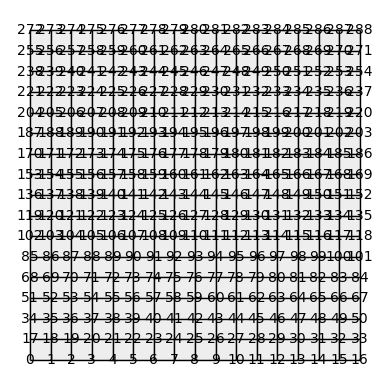

In [4]:
#dense mesh
job_directory=os.getcwd()
data=os.path.join(job_directory,"Data","dense_mesh.obj")
meshdense = Mesh.from_obj(data)
plotter = MeshPlotter(meshdense, figsize=(4, 4))
plotter.draw_edges()
plotter.draw_vertices(text='key', radius=0.01)
plotter.draw_faces()
plotter.show()

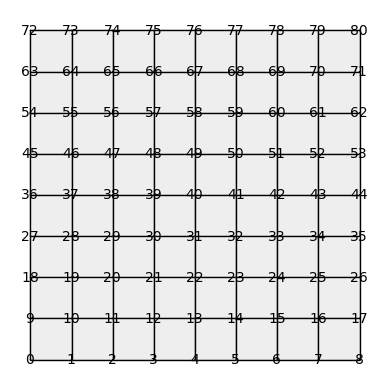

In [5]:
#transform mesh
data=os.path.join(job_directory, "Data","dense_meshquarter.obj")
mesh = Mesh.from_obj(data)
plotter = MeshPlotter(mesh, figsize=(4, 4))
plotter.draw_edges()
plotter.draw_vertices(text='key', radius=0.01)
plotter.draw_faces()
plotter.show()

In [6]:
#select points
random_point=[72]
random_select=[1]
x_sub=8
y_sub=8

In [7]:
#select verices in 1/4 of the mesh
vertices = list(mesh.vertices())
temp=x_sub+1
temp=int(temp)
tempb=x_sub/2
tempb=int(tempb)
v=[]

for i in range(tempb+1):
    v.append(vertices[i])
a=v
t=[i+(temp) for i in a]
v=v+t
for i in range (tempb-1):
    t=[i+(temp) for i in t]
    v=v+t
vertices=v

[0, 1, 2, 3, 4, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 27, 28, 29, 30, 31, 36, 37, 38, 39, 40]


In [7]:
def transformmesh(mesh,random_point,random_select,x_sub,y_sub): #this is 
    boundary_vertices = mesh.vertices_on_boundary()
    corner_points=[72,80,0,8]
    #find symmetries
    p_lst=[]
    for i in random_point:
        p_lst.append(neigh(mesh,i))
    r_lst=[]
    for i in range(len(random_point)):
        temp=p_lst[i]
        indx=random_select[i]
        tempb=temp[indx]
        r_lst.append(tempb)
    syma=[]
    for i in r_lst:
        a= symmetrical_points(mesh,x_sub,y_sub,i)
        syma.append(a)
    symb=[]
    for i in random_point:
        a= symmetrical_points(mesh,x_sub,y_sub,i)
        symb.append(a)
    syma=flatten(syma)
    symb=flatten(symb)
    temp_lst=[]
    for i in range (len(syma)):
        l=[syma[i],symb[i]]
        temp_lst.append(l)
    G = to_graph(temp_lst)
    lst_new=list(connected_components(G))
    pts_to_merge=[]

    for i in range(len(lst_new)):
        temp=lst_new[i]
        t=list(temp)
        pts_to_merge.append(t)
    
    print (pts_to_merge)

    #Resulting point after merfing selected points
    merged_points=[]

    for i in pts_to_merge:
        tempb=checklists(i,corner_points)
        if len(tempb)== 0:
            temp=checklists(i,boundary_vertices)        
            if len(temp)==1:#if there is one boundary point in the points_to_merge select it as the resulting point
                tempa=Mesh.vertex_coordinates(mesh, temp[0], axes='xyz')
                merged_points.append(tempa)            
            elif len(temp)>1:#if there is more than one boundary point in the points_to_merge, select their centre as the resulting point
                merged_points.append(find_centre(mesh,temp))
            else:#if there is no boundary point in the points_to_merge, select their centre as the resulting point
                merged_points.append(find_centre(mesh,i))
        else:#if there is a corner point in the points_to_merge, select it as the resulting point
            tempc=checklists(i,corner_points)
            tempc=Mesh.vertex_coordinates(mesh, tempc[0], axes='xyz')
            merged_points.append(tempc)

    #Indexes for vertices, edges and faces
    vertices = list(mesh.vertices())
    edges = list(mesh.edges())
    faces = list(mesh.faces())

    #list with face structure
    faces_structure=[]
    for f in faces:
        faces_structure.append(mesh.face_vertices(f))

    #list of coordinates for all vertices
    vertices = list(mesh.vertices())
    vertices_coordinates=[]
    for i in vertices:
        i_coordinates=Mesh.vertex_coordinates(mesh, i, axes='xyz')
        vertices_coordinates.append(i_coordinates)
    x=-1
    for i in pts_to_merge:
        x=x+1
        for e in i:
            vertices_coordinates[e]=merged_points[x]

    #new mesh
    mesh2 = Mesh.from_vertices_and_faces(vertices_coordinates, faces_structure)
    training_vertices = vertices_coordinates
    #dictionaries of vertices&faces
    vertices_dict=dict(zip(vertices, vertices_coordinates))
    faces_dict=dict(zip(faces,faces_structure))

    #clear faces with zero area
    faces = list(mesh2.faces())
    faces_structure=[]
    for i in faces:
        faces_structure.append(mesh2.face_vertices(i))
    vertices_coordinates=mesh_vertex_coordinates(mesh2)
    i=0
    l_temp=[]

    for i in range(len(faces)):#get a list with the indexes of faces with zero area
        t= (face_coor(mesh2,i))
        a=area_polygon(t)    
        if abs(a)<0.001:
            #del faces_structure[i]
            l_temp.append(i)        
        i=i+1
    temp=0

    for i in l_temp:
        del faces_structure[i-temp]
        temp=temp+1

    for i in l_temp:
        del faces_dict[i]

    #remove no used vertices
    faces_structure_flatten=flatten(faces_structure)
    temp=[]
    for i in vertices:
        if i in faces_structure_flatten:
            pass
        else: 
            temp.append(i)
    for i in temp:
        del vertices_dict[i]

    #new mesh
    mesh3 = Mesh.from_vertices_and_faces(vertices_dict, faces_dict)
    mesh_delete_duplicate_vertices(mesh3, precision=None)

    #fix the index of vertices
    vertices = list(mesh3.vertices())
    vertices_coordinates=[]
    for i in vertices:
        i_coordinates=Mesh.vertex_coordinates(mesh3, i, axes='xyz')
        vertices_coordinates.append(i_coordinates)

    faces = list(mesh3.faces())
    faces_structure=[]
    for f in faces:
        faces_structure.append(mesh3.face_vertices(f))

    i=0
    vertices_new=[]
    for v in vertices:
        vertices_new.append(i)
        i=i+1
    lstold=[]
    lstnew=[]
    i=0
    for v in vertices:
        if vertices[i] != vertices_new[i]:
            lstold.append(v)
            lstnew.append(vertices_new[i])
        i=i+1
    res = {lstold[i]: lstnew[i] for i in range(len(lstold))}
    e=0
    faces_structure_new= faces_structure
    for f in faces_structure_new:
        z=0
        for i in f:
            if i in lstold:
                faces_structure_new[e][z]=res[i]
            z=z+1
        e=e+1    
    mesh4 = Mesh.from_vertices_and_faces(vertices_coordinates, faces_structure_new)

    
    return (mesh4,pts_to_merge)
    


In [8]:
def get_adjmatrix(mesh4,meshdense):
    vertices_old = list(meshdense.vertices())
    v_old=[]
    for i in vertices_old:
        i_coordinates_old=Mesh.vertex_coordinates(meshdense, i, axes='xyz')
        v_old.append(i_coordinates_old)

    vertices_new = list(mesh4.vertices())
    v_new=[]
    for i in vertices_new:
        i_coordinates_new=Mesh.vertex_coordinates(mesh4, i, axes='xyz')
        v_new.append(i_coordinates_new)

    #Create empty matrix
    adjmatrix=np.zeros((289, 289))

    faces_new = list(mesh4.faces())
    faces_structure_new=[]
    for f in faces_new:
        faces_structure_new.append(mesh4.face_vertices(f))


    #Create a dictionary --> (vertex index in new mesh): (vertex index in dense mesh)
    dict_temp= {}
    for i in range(len(v_old)):
        if v_old[i] in v_new: 
            temp={(v_new.index(v_old[i])):i}
            dict_temp.update(temp)

    #Replace the vertex index in faces structure of the dense mesh
    z=0
    for i in faces_structure_new:
        for y in range(len(i)):

            (faces_structure_new[z])[y]=dict_temp[(faces_structure_new[z])[y]]
        z=z+1

    #create adjacency matrix
    for i in faces_structure_new:
        if len(i)==4:
            adjmatrix[(i[0]),(i[1])]=1.0
            adjmatrix[(i[1]),(i[0])]=1.0
            adjmatrix[(i[1]),(i[2])]=1.0
            adjmatrix[(i[2]),(i[1])]=1.0
            adjmatrix[(i[2]),(i[3])]=1.0
            adjmatrix[(i[3]),(i[2])]=1.0      
            adjmatrix[(i[3]),(i[0])]=1.0     
            adjmatrix[(i[0]),(i[3])]=1.0
        if len(i)==3:
            adjmatrix[(i[0]),(i[1])]=1.0
            adjmatrix[(i[1]),(i[0])]=1.0
            adjmatrix[(i[1]),(i[2])]=1.0
            adjmatrix[(i[2]),(i[1])]=1.0
            adjmatrix[(i[2]),(i[0])]=1.0
            adjmatrix[(i[0]),(i[2])]=1.0


    #relaxed_mesh=relax(timeout = 2,m=mesh4)
    
    return (adjmatrix)
    


In [ ]:
v_lenght=len(vertices)
range_ver=(v_lenght/4)-(v_lenght/8)
range_ver=round(range_ver)
range_neigh=7
seed(2)
choices(vertices, k=3)
# generate some integers
num=[]
interations=0
#dataset=[np.zeros((1,289,289),dtype=float)]
dataset=[]
doublemesh=0
pointstomerge_list=[]

#dataset creation!!!
for i in range(11000): #this number is not final because the generation will produce double results
	try:
		ram_range_ver = randint(1, range_ver)
		random_point=choices(vertices, k=ram_range_ver)
		len(random_point)
		random_select = []
		for i in range(len(random_point)):
			temp=neigh(mesh,random_point[i])
			temp=len(temp)-1
			n = randint(0,temp)
			random_select.append(n)
		transform=transformmesh(mesh,random_point,random_select,x_sub,y_sub)
		tmesh=transform[0]
		pointstomerge=transform[1]
		area=Mesh.area(tmesh)
		relaxed_mesh=relax(timeout = 2,m=tmesh)
		mtx=get_adjmatrix(tmesh,meshdense)
		mtx2=mtx.reshape(1,289,289)
		if pointstomerge in pointstomerge_list:
			doublemesh=doublemesh+1	
		if area==225 and pointstomerge not in pointstomerge_list :
			dataset.append(mtx)
			vertices_and_faces=relaxed_mesh.to_vertices_and_faces()	
			dir="C:/Users/31613/Documents/2021/Graduation/P4/Trainning_data/FEM/"
			str_interations=str(interations).zfill(4)
			dir_vert=dir+str_interations+"_vertices.txt"
			f =open(dir_vert, "w")
			for i in vertices_and_faces[0]:
				r=str(i)
				r=r.replace('[', '{')
				r=r.replace(']', '}')
				f.write(r+"/")
			f.close()

			dir_faces=dir+str_interations+"_faces.txt"		
			f =open(dir_faces, "w")
			for i in vertices_and_faces[1]:
				w=str(i)
				w=w.replace('[', '{')
				w=w.replace(']', '}')
				f.write(w+"/")
			f.close()
			interations=interations+1
			pointstomerge_list.append(pointstomerge)	
			print("iteration",interations)

	except IndexError:
		print ("error")
	except AttributeError:
		print ("error")
	except ValueError:
		print ("error")
		
